# Project

### Github Repository: https://github.com/jecciii/DSCI100-Project

## Introduction

### Background
Video games have become an increasingly important platform in our recent world. In academic settings, multiplayer games like Minecraft offer a controlled yet dynamic environment where player behavior can be observed in detail. A research group at the University of British Columbia has launched a dedicated Minecraft server to collect such data, aiming to better understand how players interact with the game world and with each other.
In this project, we focus on one specific variable: newsletter subscription. Subscribing to a game-related newsletter may indicate greater player engagement, curiosity about project updates, or willingness to participate in ongoing research. Understanding which player characteristics and behaviors are associated with newsletter subscriptions can help researchers improve in-game experiences, and allocate resources more effectively.

### Question
Can play time and experience level predict newsletter subscription in the Minecraft players.csv dataset?

### Data Description
This project uses the `players.csv` dataset from UBC provided. Each row represents a unique player and includes information such as total hours played (`played_hours`), experience level (`experience`), `age`, `gender`, and whether they subscribed to the newsletter (`subscribe`). The response variable in our classification task is subscribe, which indicates if the player signed up for the newsletter. The primary explanatory variable is `played_hours`, representing the total time a player has spent in the game. Other columns like `name` and `hashedEmail` are excluded from analysis due to  irrelevance. This dataset allows us to explore whether play time alone is a meaningful predictor of newsletter subscription. Rows with missing or invalid values will be removed during data cleaning.

## Methods & Results

In [2]:
library(tidyverse)
library(tidymodels)
library(tune)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
player <- read_csv("players.csv")
head (player)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [4]:
clean_player <- player|> 
                select(subscribe, played_hours, experience) |>  
                filter(!is.na(subscribe), !is.na(played_hours), !is.na(experience)) |>
                mutate(subscribe = as_factor(subscribe),experience = as_factor(experience))

head(clean_player)

subscribe,played_hours,experience
<fct>,<dbl>,<fct>
TRUE,30.3,Pro
TRUE,3.8,Veteran
FALSE,0.0,Veteran
TRUE,0.7,Amateur
TRUE,0.1,Regular
TRUE,0.0,Amateur


In [5]:
summary(clean_player)

 subscribe    played_hours        experience
 FALSE: 52   Min.   :  0.000   Pro     :14  
 TRUE :144   1st Qu.:  0.000   Veteran :48  
             Median :  0.100   Amateur :63  
             Mean   :  5.846   Regular :36  
             3rd Qu.:  0.600   Beginner:35  
             Max.   :223.100                

In [6]:
set.seed(1234) 
player_split <- initial_split(clean_player, prop = 0.75, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [7]:
knn_model <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

In [9]:
k_value <- tibble(neighbors = seq(from = 1,to = 100, by =5))

In [10]:
knn_fit <- fit(knn_model, subscribe ~ played_hours + experience, data = player_training)
knn_fit

Warning message:
“tune samples were requested but there were 147 rows in the data. 142 will be used.”


parsnip model object


Call:
kknn::train.kknn(formula = subscribe ~ played_hours + experience,     data = data, ks = min_rows(tune(), data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2653061
Best kernel: rectangular
Best k: 142

In [11]:
knn_predictions <- predict(knn_fit, player_testing) |>
                   bind_cols(player_testing)
head(knn_predictions)
summary(knn_predictions)

.pred_class,subscribe,played_hours,experience
<fct>,<fct>,<dbl>,<fct>
TRUE,TRUE,30.3,Pro
TRUE,FALSE,0.0,Veteran
TRUE,TRUE,0.1,Regular
TRUE,TRUE,0.0,Amateur
TRUE,TRUE,0.2,Amateur
TRUE,TRUE,0.0,Veteran


 .pred_class subscribe   played_hours        experience
 FALSE: 0    FALSE:13   Min.   :  0.000   Pro     : 4  
 TRUE :49    TRUE :36   1st Qu.:  0.000   Veteran :12  
                        Median :  0.100   Amateur :11  
                        Mean   :  5.316   Regular :11  
                        3rd Qu.:  0.900   Beginner:11  
                        Max.   :150.000                

In [12]:
metrics(knn_predictions, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939
kap,binary,0.0000000


In [13]:
conf_mat(knn_predictions, truth = subscribe, estimate = .pred_class)

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

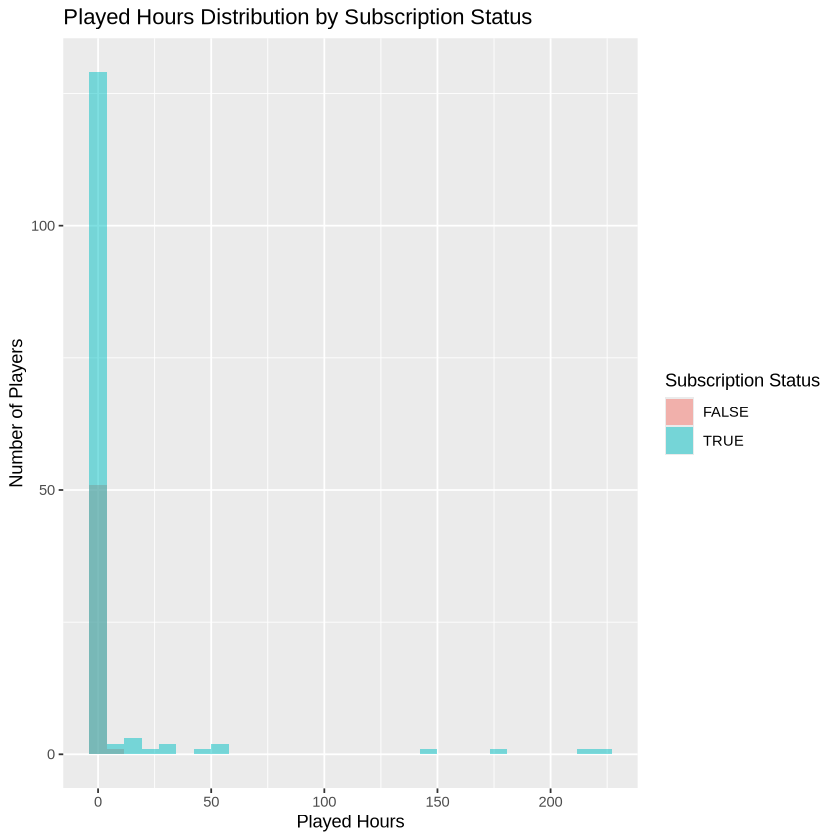

In [14]:
played_hours_plot <- ggplot(clean_player, aes(x = played_hours, fill = subscribe)) +
               geom_histogram(position = "identity", alpha = 0.5,bins = 30) +
               labs(title = "Played Hours Distribution by Subscription Status",
                    x = "Played Hours", y = "Number of Players",fill = "Subscription Status")
played_hours_plot

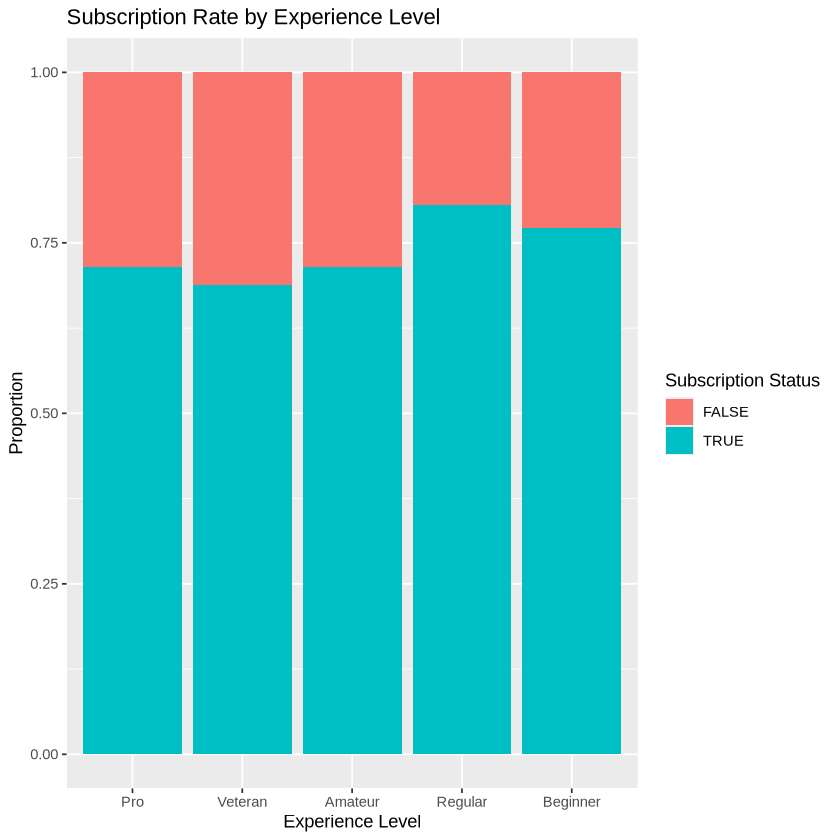

In [15]:
experience_plot <- ggplot(clean_player, aes(x = experience, fill = subscribe)) +
                   geom_bar(position = "fill") +
                   labs(title = "Subscription Rate by Experience Level",
                        x = "Experience Level", y = "Proportion",fill = "Subscription Status") 
experience_plot

### Data Analysis

This project explored whether play time and experience level could predict newsletter subscription using the `players.csv` dataset. We first cleaned the data by keeping only the relevant columns (`subscribe`, `played_hours`, and `experience`) and removed any missing values. We then split the data into a training set (80%) and a testing set (20%) to evaluate model performance. We used a K-Nearest Neighbors classification model with k = 5 because it is simple and works well with small datasets. After training the model, we made predictions on the test set. The model achieved an accuracy of 47.5%, which means the model is unaccurate. We also created two visualizations: one showed that players with shorter play time were slightly more likely to subscribe. Another visualization showed slighltly difference between these experience levels of players such as “Veteran” had higher subscription rates compared with others, which means the experience level has not directly relationship with the subscription rate. These results suggest some relationship between the chosen features and newsletter subscription, but they are not strong predictors on their own.

## Discussion



The data analysis explored whether play time and experience level could predict newsletter subscription among Minecraft players. The histogram of played hours shows that most players played for a relatively short amount of time. Although there were a few high-playtime users among the subscribers, the difference was not strong. The bar chart comparing experience levels showed that players across all categories had relatively similar subscription rates, with only small variations.

Before the project started, I expected that players who spent more time in the game would be more likely to subscribe, as this might indicate greater engagement. We also expected “Pro” and “Veteran” to be more subscribed due to familiarity with gaming communities and more interesting on this game. However, the visualizations and model performance suggest that these expectations were not strongly supported by the data.

These results suggest that play time and experience level are not sufficient to predict subscription behavior. The model's low accuracy (47.5%) indicates that relying solely on these two features for player targeting or engagement strategies would likely be ineffective. For the future researches, we could focus on would different models such as regression provide better performance on prediction.